# Sea Level Rise

### Eric Pham, Ylesia Wu, Zoe Ludena
### January 27, 2025

Models sea level rise as a function of temperature anomaly: dH/dt = a(T-T0) + e. From Rahmstorf 2007 paper. Need emulator output files to run, and satellite data, 'global_basin_timeseries.xlsx', for actual SLR for training linear regression model and comparison.

In [43]:
'''Import Statements'''

import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge

from eofs.xarray import Eof
from glob import glob

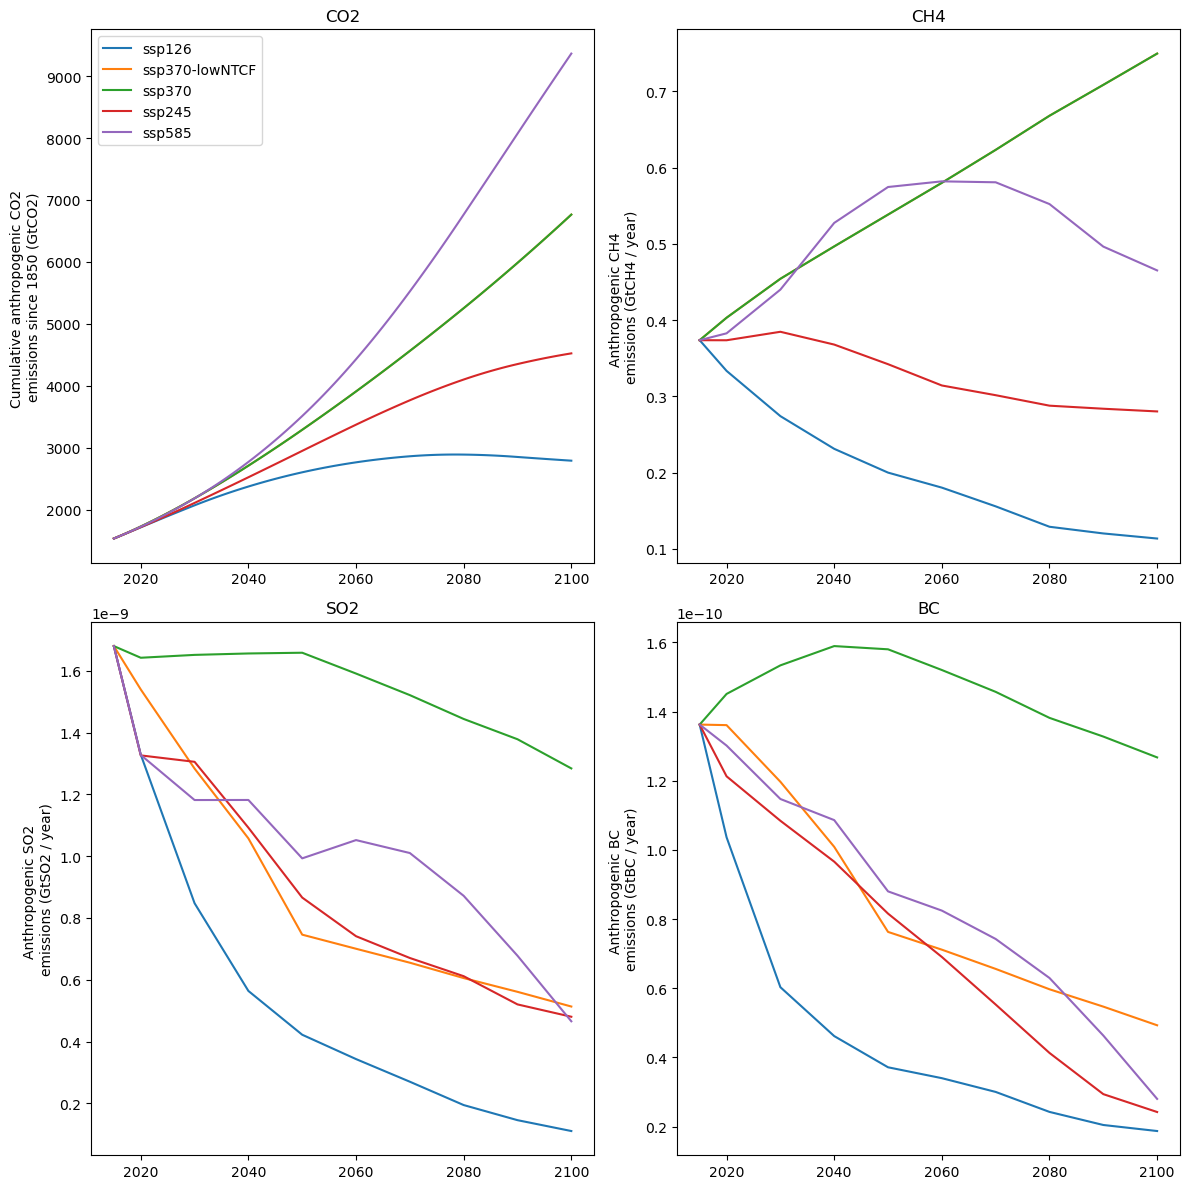

In [44]:
'''Process Emulator Inputs'''

# Change this path to where your emulator outputs are stored. We are training
# the SLR model on historical data and predicting on SSP data.
data_path = "ClimateBench/"

inputs = glob(data_path + "inputs_s*.nc")
SECONDS_IN_YEAR = 60*60*24*365 #s

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    # Need this block and the next for the weights.
    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

In [115]:
'''More Input Processing'''

# Get one combined historical + ssp585 + ssp126 + ssp370 timeseries for now
X = xr.concat([xr.open_dataset(data_path + 'inputs_historical.nc'), xr.open_dataset(data_path + 'inputs_ssp585.nc'),xr.open_dataset(data_path+ 'inputs_ssp126.nc'),xr.open_dataset(data_path+ 'inputs_ssp370.nc')], dim='time').compute()

# Take the 2nd ensemble member for the historical (the first one has some missing DTR values for some reason...) and the 1st one for ssp585, ssp126, ssp370
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2), xr.open_dataset(data_path + 'outputs_ssp585.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp126.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp370.nc').sel(member=1)], dim='time').compute()

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

X["time"]=np.arange(1,424) 
Y["time"]=np.arange(1,424)

# Need the weights here as well. Very important in order to weight
# the output file TAS variables.
weights = np.cos(np.deg2rad(Y.lat))
global_mean_temp = Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

historical_tas = xr.open_dataset("ClimateBench/outputs_historical.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()
ssp126_tas = xr.open_dataset("ClimateBench/outputs_ssp126.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()
ssp245_tas = xr.open_dataset("ClimateBench/outputs_ssp245.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()
ssp370_tas = xr.open_dataset("ClimateBench/outputs_ssp370.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()
ssp585_tas = xr.open_dataset("ClimateBench/outputs_ssp585.nc")["tas"].weighted(weights).mean(['lat', 'lon', 'member']).to_pandas()

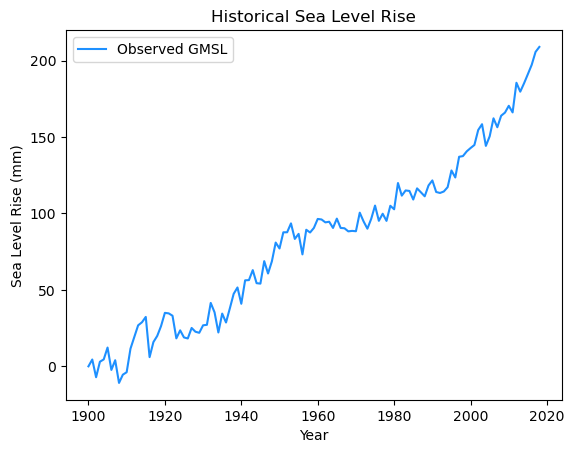

In [140]:
'''Plot of Historical Sea Level'''

more_sl = pd.read_excel("global_basin_timeseries.xlsx", index_col=0)
gmsl = more_sl[["Observed GMSL [mean]"]]
gmsl_anom = gmsl - gmsl.loc[1900]

plt.plot(gmsl_anom, label='Observed GMSL', color='dodgerblue', linestyle='-')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('Historical Sea Level Rise')
plt.show()

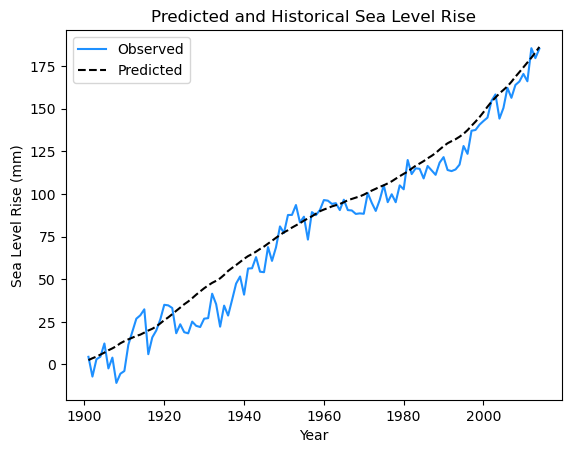

10.612898503759924


In [151]:
'''Regress SLR on Temperature Anomaly'''

### IMPORTANT FIX THIS! FIGURE OUT WHAT BASELINE FOR TEMPERATURE ANOMALY.
### MAKE SURE ALIGNS WITH SLR BASELINE YEAR.
# Features (temperature anomaly) and target (rate of sea level rise)
X_hist = historical_tas.loc[1901:2014].values.reshape(-1, 1)
y = gmsl_anom.diff().loc[1901:2014].values.reshape(-1, 1)

# Fit the linear regression model
hist_model = LinearRegression()
hist_model.fit(X_hist, y)

# Extract the parameter 'a'
a = hist_model.coef_[0]
intercept = hist_model.intercept_

MSE_TAS = sum((hist_sl['Observed GMSL [mean]'] - hist_sl['pred_sea_level_rise']) ** 2) / hist_sl.shape[0]

hist_sl = pd.DataFrame({"year": range(1901, 2015), "pred dH_dt (mm/yr)": hist_model.predict(X_hist).flatten()})
hist_sl = hist_sl.set_index("year")
hist_sl = hist_sl.join(gmsl_anom, how='left')
hist_sl['pred_sea_level_rise'] = intercept + hist_sl['pred dH_dt (mm/yr)'].cumsum()
plt.plot(hist_sl['Observed GMSL [mean]'], 
         label='Observed', linestyle='-', color='dodgerblue')
plt.plot(hist_sl['pred_sea_level_rise'], 
         label='Predicted', linestyle='--', color='black')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('Predicted and Historical Sea Level Rise')
plt.show()
print(MSE_TAS ** 0.5)

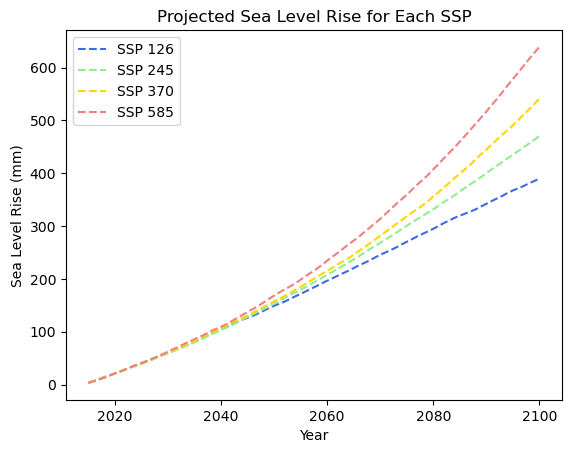

In [128]:
# Features (temperature anomaly) and target (rate of sea level rise)
X_ssp126 = ssp126_tas.values.reshape(-1, 1)
X_ssp245 = ssp245_tas.values.reshape(-1, 1)
X_ssp370 = ssp370_tas.values.reshape(-1, 1)
X_ssp585 = ssp585_tas.values.reshape(-1, 1)

ssp_sl = pd.DataFrame({"year": range(2015, 2101), 
                       "pred ssp126": hist_model.predict(X_ssp126).flatten(),
                       "pred ssp245": hist_model.predict(X_ssp245).flatten(), 
                       "pred ssp370": hist_model.predict(X_ssp370).flatten(),
                       "pred ssp585": hist_model.predict(X_ssp585).flatten(),
                      }).set_index("year").cumsum()

plt.plot(ssp_sl['pred ssp126'], 
         label='SSP 126', linestyle='--', color='royalblue')
plt.plot(ssp_sl['pred ssp245'], 
         label='SSP 245', linestyle='--', color='lightgreen')
plt.plot(ssp_sl['pred ssp370'], 
         label='SSP 370', linestyle='--', color='gold')
plt.plot(ssp_sl['pred ssp585'], 
         label='SSP 585', linestyle='--', color='lightcoral')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('Projected Sea Level Rise for Each SSP')
plt.show()

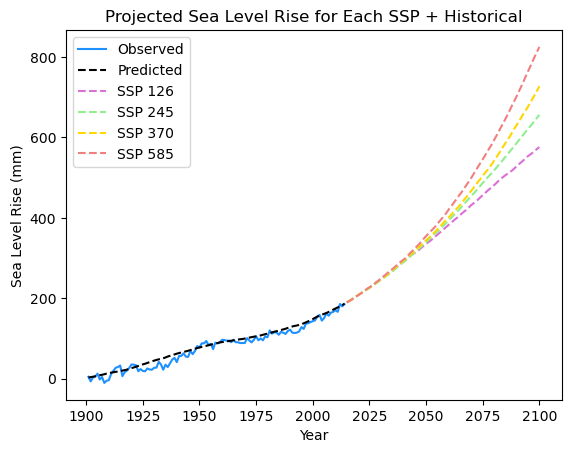

In [134]:
plt.plot(hist_sl['Observed GMSL [mean]'], 
         label='Observed', linestyle='-', color='dodgerblue')
plt.plot(hist_sl['pred_sea_level_rise'], 
         label='Predicted', linestyle='--', color='black')
plt.plot(ssp_sl['pred ssp126'] + hist_sl['pred_sea_level_rise'].loc[2014], 
         label='SSP 126', linestyle='--', color='orchid')
plt.plot(ssp_sl['pred ssp245'] + hist_sl['pred_sea_level_rise'].loc[2014], 
         label='SSP 245', linestyle='--', color='lightgreen')
plt.plot(ssp_sl['pred ssp370'] + hist_sl['pred_sea_level_rise'].loc[2014], 
         label='SSP 370', linestyle='--', color='gold')
plt.plot(ssp_sl['pred ssp585'] + hist_sl['pred_sea_level_rise'].loc[2014], 
         label='SSP 585', linestyle='--', color='lightcoral')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('Projected Sea Level Rise for Each SSP + Historical')
plt.show()

In [131]:
total_sl = hist_sl[['Observed GMSL [mean]', 'pred_sea_level_rise']].join(ssp_sl, how="outer")

for ssp in ['126', '245', '370', '585']:
    total_sl[f"pred ssp{ssp}"] = total_sl['pred_sea_level_rise'].loc[2014] + total_sl[f"pred ssp{ssp}"]

total_sl

,Observed GMSL [mean],pred_sea_level_rise,pred ssp126,pred ssp245,pred ssp370,pred ssp585
year,,,,,,
1901,4.459767,2.534328,NaN,NaN,NaN,NaN
1902,-7.128525,3.631860,NaN,NaN,NaN,NaN
1903,2.993610,4.560167,NaN,NaN,NaN,NaN
1904,4.541371,5.756806,NaN,NaN,NaN,NaN
1905,12.280013,6.927285,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2096,NaN,NaN,557.451983,628.014750,686.527541,776.530980
2097,NaN,NaN,561.833268,634.764257,696.611232,789.020730
2098,NaN,NaN,566.796575,641.975794,706.324907,801.648445


### Does CO2 Work Just As Well?

Work in Progress, But not relevant to emulators since it's using the inputs files.

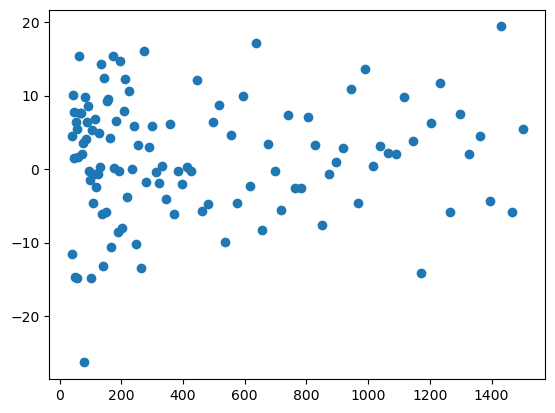

In [104]:
X_CO2 = xr.open_dataset('ClimateBench/inputs_historical.nc').sel(time=slice(1901, 2014))['CO2']
plt.scatter(X_CO2, y)

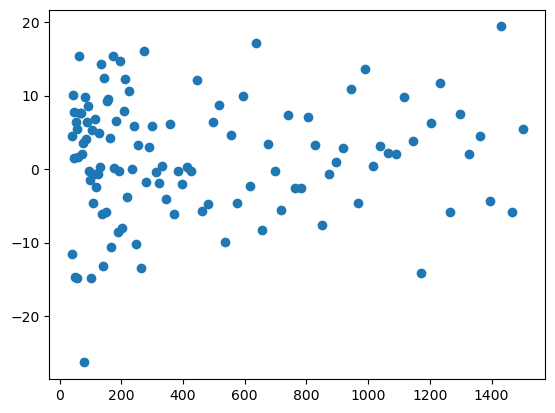

In [107]:
plt.scatter(X_hist, y)

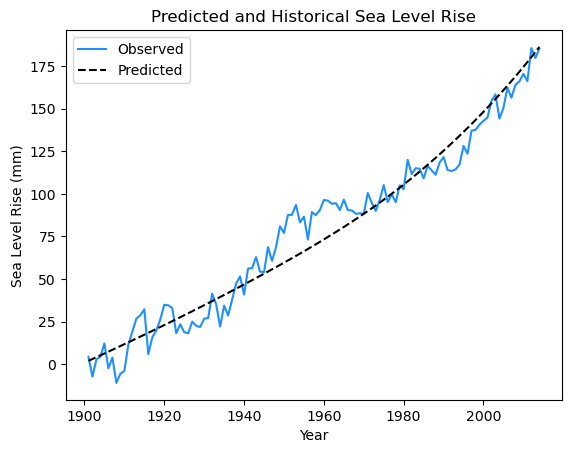

11.096775872836563


In [150]:
'''Regress SLR on Temperature Anomaly'''

### IMPORTANT FIX THIS! FIGURE OUT WHAT BASELINE FOR TEMPERATURE ANOMALY.
### MAKE SURE ALIGNS WITH SLR BASELINE YEAR.
# Features (temperature anomaly) and target (rate of sea level rise)
#X_hist = historical_tas.loc[1901:2014].values.reshape(-1, 1)
X_CO2 = xr.open_dataset('ClimateBench/inputs_historical.nc').sel(time=slice(1901, 2014))['CO2'].values.reshape(-1, 1)
y_CO2 = gmsl_anom.diff().loc[1901:2014].values.reshape(-1, 1)

# Fit the linear regression model
CO2_model = LinearRegression()
CO2_model.fit(X_CO2, y_CO2)

# Extract the parameter 'a'
a = CO2_model.coef_[0]
intercept = CO2_model.intercept_

MSE_CO2 = sum((CO2_sl['Observed GMSL [mean]'] - CO2_sl['pred_sea_level_rise']) ** 2) / CO2_sl.shape[0]

CO2_sl = pd.DataFrame({"year": range(1901, 2015), "pred dH_dt (mm/yr)": CO2_model.predict(X_CO2).flatten()})
CO2_sl = CO2_sl.set_index("year")
CO2_sl = CO2_sl.join(gmsl_anom, how='left')
CO2_sl['pred_sea_level_rise'] = intercept + CO2_sl['pred dH_dt (mm/yr)'].cumsum()
plt.plot(CO2_sl['Observed GMSL [mean]'], 
         label='Observed', linestyle='-', color='dodgerblue')
plt.plot(CO2_sl['pred_sea_level_rise'], 
         label='Predicted', linestyle='--', color='black')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('Predicted and Historical Sea Level Rise')
plt.show()
print(MSE_CO2 ** 0.5)